<a href="https://colab.research.google.com/github/AamirJafaq/CustomerSigmention.KMeansDBSCAN/blob/main/Clustering_KMeansDBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2: Customer Segmentation

Classify the customers based on their annual income and spending score using KMeans and DBSCAN. Comparing both techniques and analyze average spending per cluster.

* Dataset (Recommended): Mall Customer (Kaggle)
* Cluster customers into segments based on income and spending score
* Perform scaling and visual exploration of groupings
* Apply K-Means clustering and determine optimal number of clusters
* Visualize clusters using 2D plots
* Try different clustering algorithms (e.g., DBSCAN)
* Analyze average spending per cluster

## KMeans Clustering

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data=pd.read_csv("https://raw.githubusercontent.com/AamirJafaq/CustomerSigmention.KMeansDBSCAN/refs/heads/main/Mall_Customers.csv")
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
data.isna().sum()

,0
CustomerID,0
Genre,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


Notice that the columns have no missing values

In this project, we are only interested in annual income and spending score. So, choose only Annual Income and Spending Score columns.

In [ ]:
X=data[["Annual Income (k$)", "Spending Score (1-100)"]]
X.head()

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler=StandardScaler()
scaler.fit(X)

StandardScaler()

In [ ]:
X_s=scaler.transform(X)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
inertia=[]
for i in range(10):
  model=KMeans(n_clusters=i+1, init="k-means++", n_init=5, random_state=20 )
  model.fit(X_s)
  inertia.append(model.inertia_)


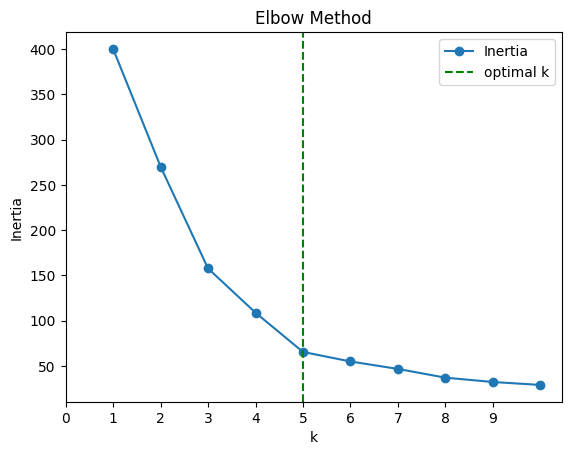

In [ ]:
plt.plot(range(1, 11),inertia, marker="o", label="Inertia")
plt.axvline(x=5, linestyle="--", color="green", label="optimal k")
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.xticks([j for j in range(10)])
plt.legend()
plt.show()

Notice that the decreasing rate of inertia shaprly slow down after the value k=5. Therefore, the optimal value of k would be k=5.

In [ ]:
kmeans=KMeans(n_clusters=5, init="k-means++", n_init=5, random_state=20 )
kmeans.fit(X_s)

KMeans(n_clusters=5, n_init=5, random_state=20)

In [ ]:
data["Cluster KMeans"]=kmeans.predict(X_s)
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster KMeans
0,1,Male,19,15,39,3
1,2,Male,21,15,81,4
2,3,Female,20,16,6,3
3,4,Female,23,16,77,4
4,5,Female,31,17,40,3


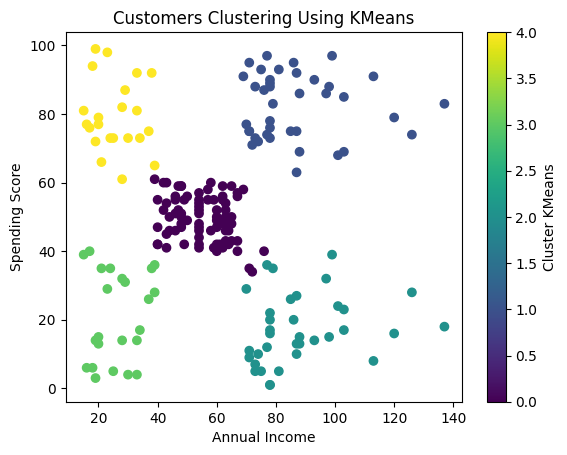

In [ ]:
plt.scatter(x=data["Annual Income (k$)"], y=data["Spending Score (1-100)"], c=data["Cluster KMeans"])
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.title("Customers Clustering Using KMeans")
plt.colorbar(label='Cluster KMeans')
plt.show()

In [ ]:
# Spliting data for each cluster.
Clusters=dict(tuple(data.groupby(data["Cluster KMeans"])))
Cluster1=Clusters[0]
Cluster2=Clusters[1]
Cluster3=Clusters[2]
Cluster4=Clusters[3]
Cluster5=Clusters[4]

In [ ]:
data.groupby("Cluster KMeans")[["Annual Income (k$)", "Spending Score (1-100)"]].mean().sort_values(by="Annual Income (k$)", ascending=False)

,Annual Income (k$),Spending Score (1-100)
Cluster KMeans,,
2,88.200000,17.114286
1,86.538462,82.128205
0,55.296296,49.518519
3,26.304348,20.913043
4,25.727273,79.363636


Notice that cluster 2 has highest average income but less spending score. However, cluster 4 has high spending score but less annual income. So, customers in cluster 2 are misers while customers of cluster 4 are extravagance. However, customers in other groups are almost spend equal proportions of their income.

Now, we will evaluate the performace of KMeans Clustering using Silhouette Score metric. It value ranges from -1 to 1. The higher the value of Silhouette Score, the better is the clustering.

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
labels=kmeans.labels_

In [ ]:
score=silhouette_score(X_s, labels)
print(f"The silhouette score for KMeans is {score:.2f}")

The silhouette score for KMeans is 0.55


Notice that the score is 0.55. It means clusters are reasonably well separated but nor perfect. There may some overlap, but not too much.

## DBSCAN Clustering

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid

In [ ]:
param_grid = {
    'eps': [0.1, 0.15, 0.3, 0.4, 0.5, 0.6, 0.8],
    'min_samples': [2,3,4,5,6]
}

In [ ]:
best_score=-1
best_params=None
clusters=None
for params in ParameterGrid(param_grid):
  dbscan=DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
  predictions=dbscan.fit_predict(X_s)
  labels, count=np.unique(predictions, return_counts=True)
  if len(labels)>2 and len(labels)<len(X_s):
    score=silhouette_score(X_s, predictions)
    if score > best_score:
      best_score=score
      best_params=params
      clusters=predictions

In [ ]:
best_params, best_score

({'eps': 0.3, 'min_samples': 3}, np.float64(0.4136187833583574))

In [ ]:
data["Cluster DBSCAN"]=clusters

In [ ]:
len(data[data["Cluster DBSCAN"]==-1])

14

The model identifies 14 points as outlier. It means the noise is not dominant.

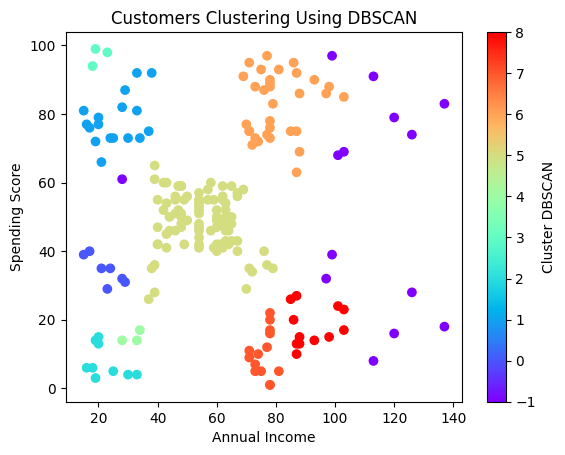

In [ ]:
plt.scatter(x=data["Annual Income (k$)"], y=data["Spending Score (1-100)"], c=data["Cluster DBSCAN"], cmap="rainbow")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.title("Customers Clustering Using DBSCAN")
plt.colorbar(label='Cluster DBSCAN')
plt.show()

Note that DBSCAN created 8 clusters, which is quite a large number. From both the visualization and the silhouette score, it is clear that the clustering quality is not as good as that of KMeans. The clusters appear less well-separated. However, DBSCAN is highly sensitive to its parameters, particularly eps and min_samples. By carefully tuning these parameters, we may be able to reduce the number of clusters, improve cluster separation, and achieve better clustering accuracy. Therefore, further parameter optimization could lead to improved performance and more meaningful clusters.